# Levenshtein distance between synthetic data and student programs

In this notebook, we will train our classifier on synthetic data and run the classification task on student programs.

We use grammars that represent the probabilistic distribution of student solutions. Given that in the process of developing these grammars we referenced the students programs, in this notebook we compute the minimum edit distance between the synthetic data generated by our grammars and the original student solutions. 

With that, we will be able to evaluate which portion of our validation set may be present in our training set, and to what extent. 

First we set up the packages we'll need to use, as well as the local repositories of student data:

In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import sys
sys.path.append('..')

In [68]:
from autoplan.trainer import ClassifierTrainer
from autoplan.dataset import PrelabeledDataset, build_synthetic_dataset, build_prelabeled_dataset
from autoplan.generator import ProgramGenerator
from autoplan.vis import plot_accuracy, plot_cm, plot_loss
from autoplan.token import TokenType, PyretTokenizer, OCamlTokenizer
from scripts.rainfall_ingest import ingest_dataset

from grammars.rainfall.ocaml import Program
from grammars.rainfall.labels import GeneralRainfallLabels

from tqdm import tqdm_notebook as tqdm
import pandas as pd
import torch
import os
import numpy as np
import torch.nn as nn
from pprint import pprint
import nltk
# import matplotlib.pyplot as plt

device = torch.device('cpu')
# device = torch.device('cuda:0')
REPO_DIR = os.path.expanduser('~/autoplan')

# Student dataset

In this section, we specify and ingest the dataset of students' OCaml solutions, as well as the hyperparameters for dataset treatment that we are going to use. 

Based on the previous ablation study [] we learned that preprocessing the student dataset positively influences the classification accuracy, so we choose to preprocess student data. Additionally, we choose to normalize all identifiers (strings), as we believe the classifier should not learn to differentiate between them. 

In [69]:
dataset_name = 'T1'
student_dataset = ingest_dataset(dataset_name, preprocess=True, exclude=[TokenType.String])

In [70]:
# Run this cell optionally to see a sample of a student program
print(student_dataset.dataset[0]['source'])

let rec rainfall (alof : float list) =
  (let rec sum_helper (alof : float list) (sum : float) (counter : float) =
     (match (alof, counter) with
      | ([],0.) -> failwith "Empty list."
      | ((-999.)::_,0.) -> failwith "Empty list."
      | ([],_) -> (sum, counter)
      | ((-999.)::_,_) -> (sum, counter)
      | (hd::tl,_) ->
          if hd >= 0.
          then sum_helper tl (sum +. hd) (counter +. 1.)
          else sum_helper tl sum counter : (float* float)) in
   match sum_helper alof 0. 0. with | (s,c) -> s /. c : float)



# Synthetic dataset

In this section, we specify and generate the dataset of synthetic OCaml solutions. As such, we specify the number of samples we wish to generate, the grammar we would like to generate samples from, the labels that are used to classify these samples, as well as adaptive and unique sampling -- two hyperparameters that can be dynamically set by the user to influence dataset diversity.   

Adaptive sampling is a dataset generating technique first described in [], where dominant choices are dynamically penalized, such that rare programs are more likely to be generated within the same batch. 

Unique sampling simply forces the generator to generate unique samples.  

In [78]:
N_samples = 1000
synthetic_dataset = build_synthetic_dataset(
    GeneralRainfallLabels,
    N=N_samples,
    tokenizer=OCamlTokenizer(),
    generator=ProgramGenerator(grammar=Program(), adaptive=False),
    vocab_index=student_dataset.vocab_index,
    unique=False)

Generating programs...
Generated 463 unique programs.
Tokenizing programs...
Building dataset metadata...


In [31]:
# Run this cell optionally to see a sample program generated from our grammar
print(synthetic_dataset.dataset[1]['source'])

let rec rainfall list_name =
  let rec helper_name (list_name : int list) =
    (match list_name with
     | [] -> []
     | head::tail when head = (-999) -> []
     | head::tail when head < 0 -> helper_name tail
     | head::tail when head >= 0 -> head :: (addition_helper_name tail) : 
    int list) in
  if (List.length (helper_name list_name)) = 0
  then 0
  else
    (List.fold_right (+) helper_name list_name 0) /
      (List.length (helper_name list_name))



# Model

In this section, we specify which classification model we are going to use, 

In [72]:
model_options = {
    'model' : nn.GRU,
    'hidden_size' : 512,
    'embedding_size' : 512
}

trainer = ClassifierTrainer(synthetic_dataset, device, model_options)

In [79]:
losses = []
train_eval = []
val_eval = []

for _ in tqdm(range(50)):
    losses.append(trainer.train_one_epoch())
    train, val = trainer.eval()
    train_eval.append(train)
    val_eval.append(val)

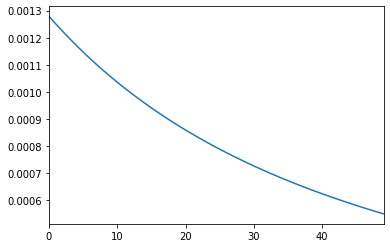

In [82]:
pd.Series(losses).plot()

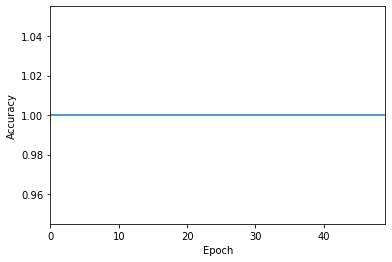

In [83]:
plot_accuracy(train_eval)

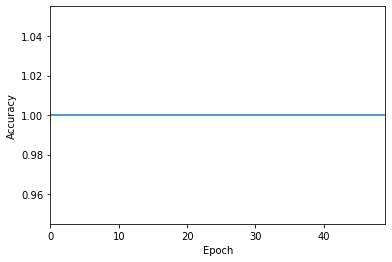

In [84]:
plot_accuracy(val_eval)

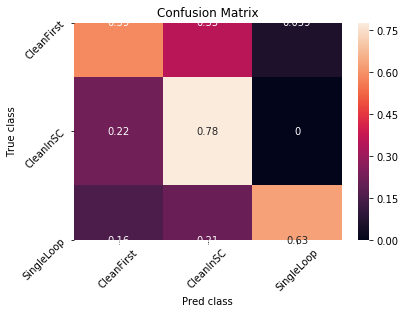

In [85]:
trainer.model.eval()
trainer.eval_on(student_dataset.loader(student_dataset.dataset)).plot_cm("Confusion Matrix", normalize=True)

# Levenshtein Distance

In [ ]:
# At the string level:

N=N_samples
edit_distance = {}

for i in range(len(student_dataset.dataset)):
    print("Analyzing student answer #", i)
    student_answer = student_dataset.dataset[i]['source']
    
    min_distance = 10000 # arbitrarily large value
    for j in range(N):
        synthetic_program = synthetic_dataset.dataset[j]['source']
        levenshtein_distance = nltk.edit_distance(student_answer, synthetic_program, transpositions=False)
        if levenshtein_distance < min_distance:
            min_distance = levenshtein_distance
            nearest_program = synthetic_program
    
    edit_distance[student_answer] = [nearest_program, min_distance]
    
    if i == len(student_dataset.dataset) - 1:
        print("Done!")

Analyzing student answer # 0
Analyzing student answer # 1


In [ ]:
for i in edit_distance:
    print("Synthetic program:")
    pprint(edit_distance[i])
    print("Nearest student solution:", i, "\n")

In [ ]:
# At the token level:

N=N_samples
edit_distance = {}

for i in range(len(student_dataset.dataset)):
    print("Analyzing student answer #", i)
    student_answer = student_dataset.dataset[i]['source']
    student_tokens = student_dataset.dataset[i]['program']
    
    min_distance = 10000 # arbitrarily large value
    for j in range(N):
        synthetic_program = synthetic_dataset.dataset[j]['source']
        synthetic_tokens = synthetic_dataset.dataset[j]['program']
        
        levenshtein_distance = nltk.edit_distance(student_tokens, synthetic_tokens, transpositions=False)
        if levenshtein_distance < min_distance:
            min_distance = levenshtein_distance
            nearest_program = synthetic_program
    
    edit_distance[student_answer] = [nearest_program, min_distance]
    
    if i == len(student_dataset.dataset) - 1:
        print("Done!")

In [ ]:
for i in edit_distance:
    print("Synthetic program:")
    pprint(edit_distance[i])
    print("Nearest student solution:", i, "\n")

In [ ]:
# Between validation set and training set, at the string level:

edit_distance = {}

for train in trainer.train_loader:
    for i in train:
        train_programs = train['source']
        for train_solution in train_programs:
            print("Analyzing a new training sample...")
            min_distance = 10000 # arbitrarily large value
            for val in trainer.val_loader:
                for j in val:
                    val_programs = val['source']
                    for val_solution in val_programs:
                        levenshtein_distance = nltk.edit_distance(train_solution, val_solution, transpositions=False)
                        if levenshtein_distance < min_distance:
                            min_distance = levenshtein_distance
                            nearest_program = val_solution
    
            edit_distance[train_solution] = [nearest_program, min_distance]

In [ ]:
for i in edit_distance:
    print("Training sample:")
    pprint(i)
    print("Nearest validation sample:")
    pprint(edit_distance[i])

In [ ]:
# Between validation set and training set, at the token level:

edit_distance = {}

for train in trainer.train_loader:
    for i in train:
        train_programs = train['program']
        for train_solution in train_programs:
            print("Analyzing a new training sample...")
            min_distance = 10000 # arbitrarily large value
            for val in trainer.val_loader:
                for j in val:
                    val_programs = val['program']
                    for val_solution in val_programs:
                        levenshtein_distance = nltk.edit_distance(train_solution, val_solution, transpositions=False)
                        if levenshtein_distance < min_distance:
                            min_distance = levenshtein_distance
                            nearest_program = val_solution
    
            edit_distance[train_solution] = [nearest_program, min_distance]

In [ ]:
for i in edit_distance:
    print("Training sample:")
    pprint(i)
    print("Nearest validation sample:")
    pprint(edit_distance[i])